# IMPORT

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px


# FUNCTIONS

In [6]:
def get_weighted_quantile_bounds(df, colonna, weight, coverage): #Restituisce un intervallo di confidenza simmetrico centrato attorno alla mediana, con un livello di copertura specificato (es. 99%), ponderando i valori tramite una colonna peso
    sorted_df = df.sort_values(by=colonna)
    cum_weights = sorted_df[weight].cumsum() #Calcola la somma cumulativa dei pesi
    total = cum_weights.iloc[-1] #calcola il totale

    #determino le soglie dei quantili, cioè se voglio il 99% dei dati, allora la soglia inferiore sarà 0.005 cioè lo 0.5% e la soglia superiore sarà il 0.995 cioè il 99.5%. Così facendo escludo solo l'1% dei dati.
    lower_cut = (1 - coverage) / 2
    upper_cut = 1 - lower_cut

    #Trovo i valori della colonna corrispondenti a quei quantili
    lower_bound = sorted_df[sorted_df[weight].cumsum() >= total * lower_cut][colonna].iloc[0] #Trova il primo valore nella colonna dove la somma cumulativa dei pesi supera total * lower_cut
    upper_bound = sorted_df[sorted_df[weight].cumsum() >= total * upper_cut][colonna].iloc[0]

    return lower_bound, upper_bound

In [7]:
def trova_outlier_IQR(df, colonna):
    Q1 = df[colonna].quantile(0.25)
    Q3 = df[colonna].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[colonna] < Q1 - 1.5 * IQR) | (df[colonna] > Q3 + 1.5 * IQR)]
    return outliers

# GET DATA

In [8]:
df_merge_def = pd.read_csv('/Users/alessandropavia/Desktop/Stage Reply/Sales Analysis 2/UV_Setup&Codice/data/processed/MasterTable.csv', parse_dates=["Order Date_def", "Ship Date_def"])


## MEDIE, MEDIANE, QUANTILI, VALORI UNICI E COLONNE SULLE DATE AGGIUNTE

In [9]:
Sales_tot=df_merge_def.groupby('State_def')['Sales_def'].sum().round(3)
media_per_stato = df_merge_def.groupby('State_def')['Sales_def'].mean().round(3)
mediana_per_stato=df_merge_def.groupby('State_def')['Sales_def'].median().round(3)
primo_quartile=df_merge_def.groupby('State_def')['Sales_def'].quantile(0.25).round(3)
terzo_quartile=df_merge_def.groupby('State_def')['Sales_def'].quantile(0.75).round(3)
percentile_95=df_merge_def.groupby('State_def')['Sales_def'].quantile(0.95).round(3)

df_statistiche = pd.DataFrame({
    'Sales_tot':Sales_tot,
    'Sales_mean': media_per_stato,
    'Sales_median': mediana_per_stato,
    'First quartile':primo_quartile,
    'Third quartile':terzo_quartile,
    '95_percentile':percentile_95
}).reset_index()

'''CONTO PER OGNI COLONNA I VALORI UNICI'''
for col in df_merge_def.columns: 
    valori_unici_col = df_merge_def[col].nunique()
    print(f"{col}: {valori_unici_col} valori unici")

print(df_merge_def['Order Date_def'].dtype)

'''AGGIUNGO COLONNA MESE, QUARTER, ANNO, DISTANZA IN GIORNI TRA SHIP DATE E ORDER DATE, TIPO DI GIORNO DELL'ORDINE(GIORNO DELLA SETTIMANA O DEL WEEKEND)'''
df_merge_def['Order Month'] = df_merge_def['Order Date_def'].dt.month_name()
df_merge_def['Order Year'] = df_merge_def['Order Date_def'].dt.year
df_merge_def['Order Quarter']=df_merge_def['Order Date_def'].dt.quarter
df_merge_def['Days between order date and shipping date']= df_merge_def['Ship Date_def'] - df_merge_def['Order Date_def']
df_merge_def['Order Day Type'] = df_merge_def['Order Date_def'].dt.dayofweek.apply(
    lambda x: 'Weekend' if x >= 5 else 'Weekday')
df_merge_def['Order Week']=df_merge_def['Order Date_def'].dt.isocalendar().week
df_merge_def['Order Day of the Week']=df_merge_def['Order Date_def'].dt.day_name()


Order ID: 5021 valori unici
Product ID_def: 1861 valori unici
Customer ID_def: 814 valori unici
Country: 1 valori unici
Region: 4 valori unici
State_def: 49 valori unici
City_def: 531 valori unici
Postal Code_def: 631 valori unici
Order Date_def: 1239 valori unici
Ship Date_def: 1334 valori unici
Ship Mode_def: 4 valori unici
Sales_def: 6080 valori unici
Profit_def: 7536 valori unici
Discount_def: 18 valori unici
Quantity_def: 17 valori unici
Segment_def: 3 valori unici
Customer Name_def: 792 valori unici
Category_def: 3 valori unici
Sub-Category_def: 17 valori unici
Order Month: 12 valori unici
Order Year: 4 valori unici
Order Quarter: 4 valori unici
Days between order date and shipping date: 15 valori unici
Order Day Type: 2 valori unici
Order Week: 52 valori unici
Order Day of the Week: 7 valori unici
datetime64[ns]


## ANALISI TEMPORALI SULLE VENDITE 

,Days between order date and shipping date,counts,days_diff
0,-231 days,1,-231
1,-174 days,1,-174
2,-56 days,1,-56
3,-4 days,1,-4
4,0 days,519,0
5,1 days,368,1
6,2 days,1332,2
7,3 days,1003,3
8,4 days,2769,4
9,5 days,2174,5


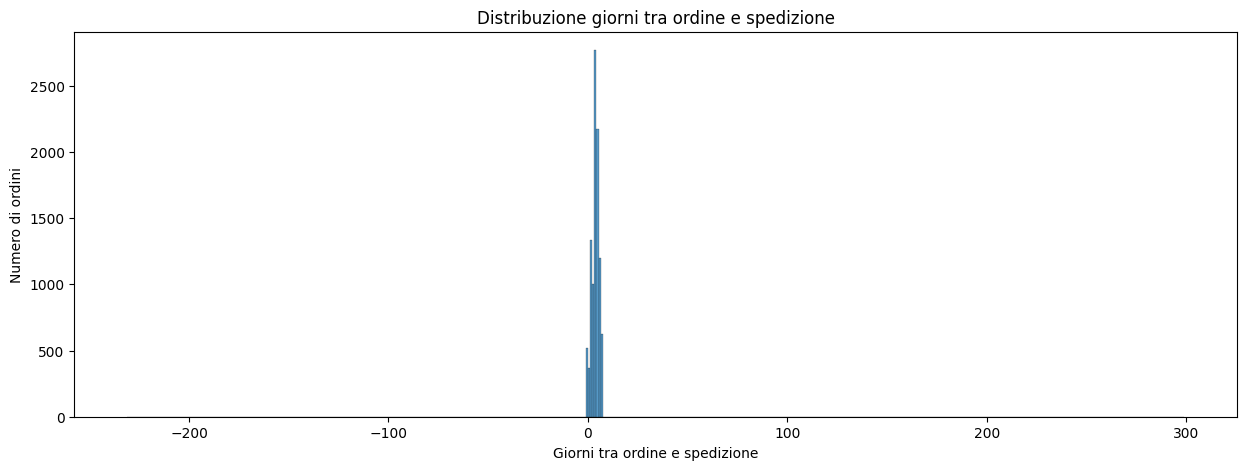

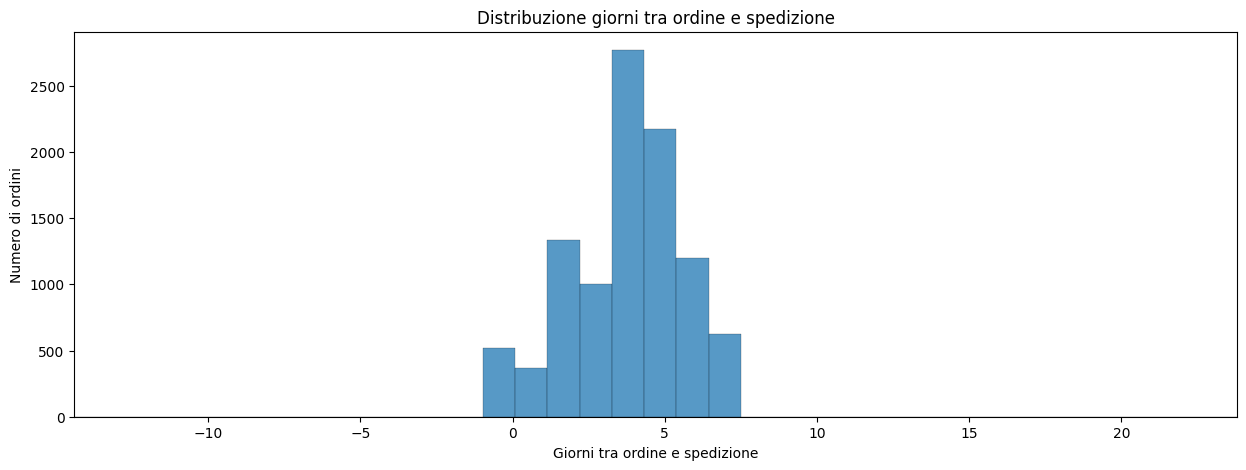

In [10]:
'''ISTOGRAMMA CON DIFFERENZA TRA SHIP DATE E ORDER DATE'''
df_groupby_days = df_merge_def.groupby('Days between order date and shipping date').size().reset_index(name='counts') #il size conta quante righe ha ciascun gruppo mentre reset_index trasforma la serie in dataframe con la colonna di differenza dei giorni e una colonna counts con le frequenze
df_groupby_days['days_diff'] = df_groupby_days['Days between order date and shipping date'].dt.days #estraggo solo il numero dei giorni
display(df_groupby_days)
plt.figure(figsize=(15,5))
sns.histplot(data=df_groupby_days, x='days_diff', weights='counts', bins= 500) #weights significa che ogni valore di "days_diff" contribuisce all’istogramma con un peso pari a "counts" — quindi se days_diff=2 ha counts=34, verrà trattato come se il valore 2 fosse presente 34 volte.
#plt.xlim(-50, 50)  # Zoom su intervallo utile
plt.xlabel('Giorni tra ordine e spedizione')
plt.ylabel('Numero di ordini')
plt.title('Distribuzione giorni tra ordine e spedizione')
plt.show() 

#STESSO GRAFICO MA CON QUANTILI SPECIFICATI
p20=df_groupby_days['days_diff'].quantile(0.20)
p80=df_groupby_days['days_diff'].quantile(0.80)
plt.figure(figsize=(15,5))
sns.histplot(data=df_groupby_days, x='days_diff', weights='counts', bins= 500)
plt.xlim(p20,p80)  # Zoom su intervallo utile
plt.xlabel('Giorni tra ordine e spedizione')
plt.ylabel('Numero di ordini')
plt.title('Distribuzione giorni tra ordine e spedizione')
plt.show()

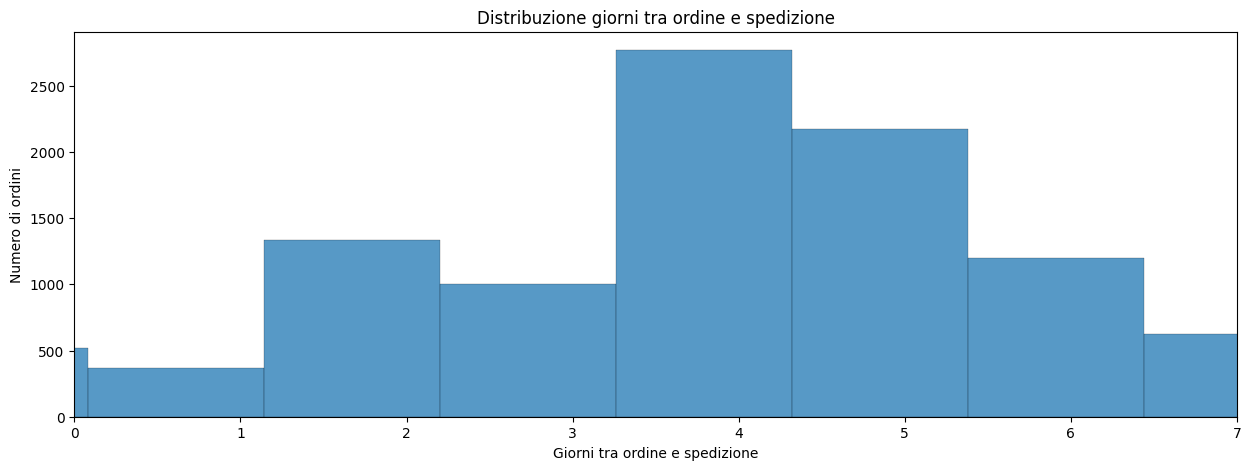

In [11]:
'''RENDO AUTOMATICO LA VISUALIZZAZIONE DEL X(COVERAGE) PERCENTUALE DEI DATI'''
p0_5, p99_5 = get_weighted_quantile_bounds(df_groupby_days, colonna='days_diff', weight='counts', coverage=0.99)

plt.figure(figsize=(15,5))
sns.histplot(data=df_groupby_days, x='days_diff', weights='counts', bins=500)
plt.xlim(p0_5, p99_5)
plt.xlabel('Giorni tra ordine e spedizione')
plt.ylabel('Numero di ordini')
plt.title('Distribuzione giorni tra ordine e spedizione')
plt.show()

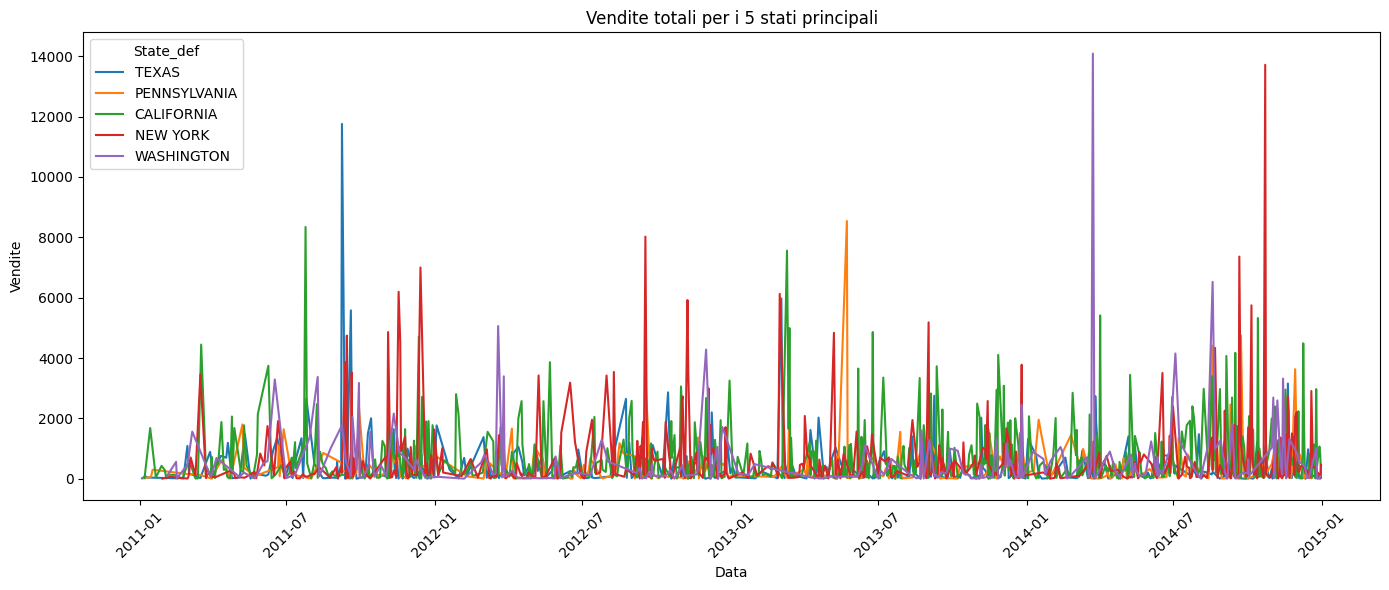

In [12]:
'''CLASSIFICA DEI 5 STATI CON PIU' SALES CON SEABORN'''
# Trova i top 5 stati
top_states2 = df_merge_def.groupby('State_def')['Sales_def'].sum().nlargest(5).index

# Filtra solo i dati di quei 5 stati
df_top = df_merge_def[df_merge_def['State_def'].isin(top_states2)]

# Raggruppa per data e stato
df_grouped4 = df_top.groupby(['Order Date_def', 'State_def'])['Sales_def'].sum().reset_index()

# Grafico lineplot
plt.figure(figsize=(14,6))
sns.lineplot(data=df_grouped4,
             x='Order Date_def',
             y='Sales_def',
             hue='State_def') #hue serve a specificare la colonna con lo stato colorato in modo diverso

plt.title('Vendite totali per i 5 stati principali')
plt.xlabel('Data')
plt.ylabel('Vendite')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/var/folders/92/7kxqqyld1rl76prg4ll1c3s40000gn/T/ipykernel_87472/2687394478.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  media_mensile = df_merge_def.groupby('Order Month')['Sales_def'].mean()


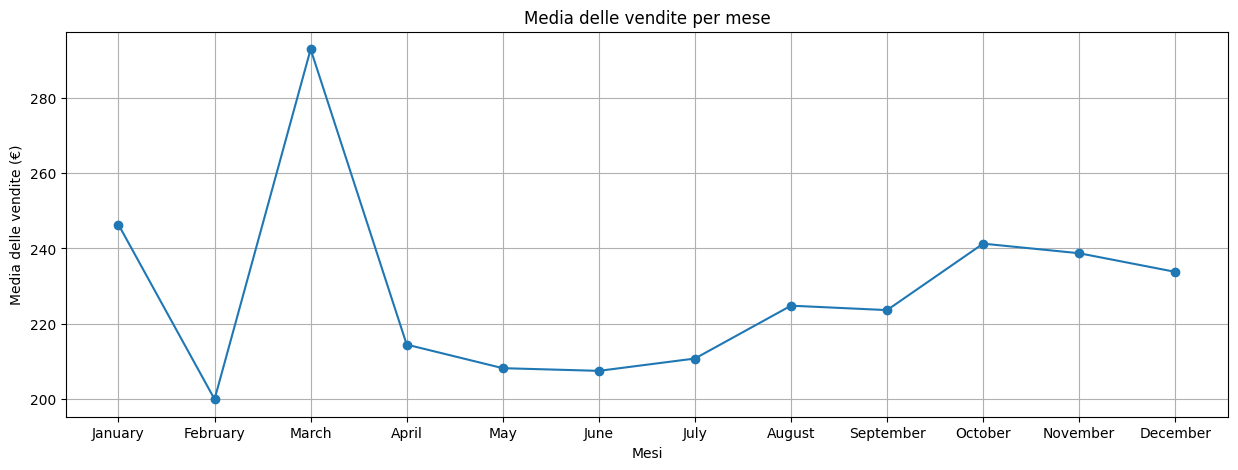

/var/folders/92/7kxqqyld1rl76prg4ll1c3s40000gn/T/ipykernel_87472/2687394478.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  media_settimanale=df_merge_def.groupby('Order Day of the Week')['Sales_def'].mean()


<function matplotlib.pyplot.show(close=None, block=None)>

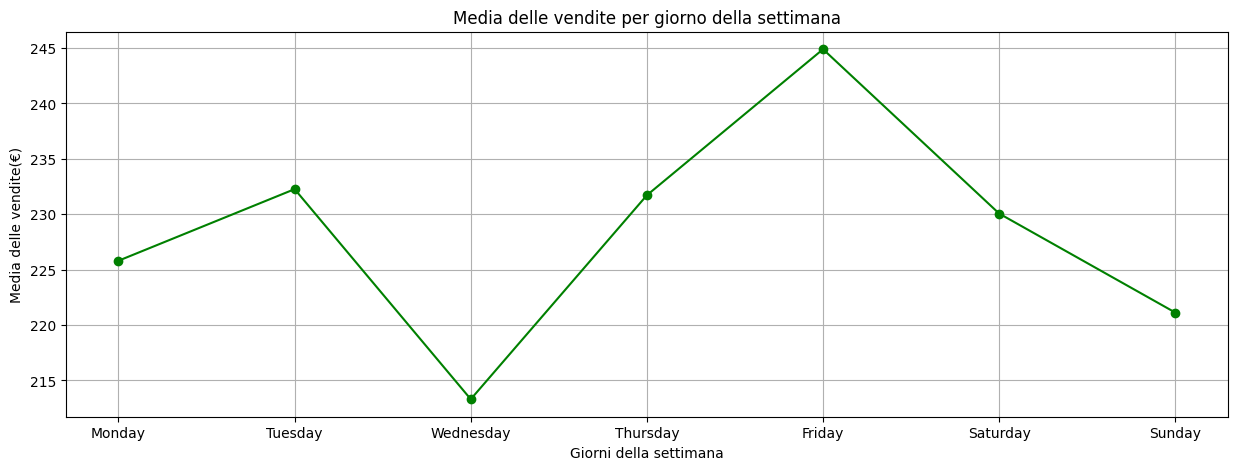

In [13]:
'''ANALISI STAGIONALE/CICLICA SULLE VENDITE'''

#ANALISI MENSILE
ordine_mesi=['January','February','March','April','May','June','July','August','September','October','November','December']
df_merge_def['Order Month'] = pd.Categorical(
    df_merge_def['Order Month'],
    categories=ordine_mesi,
    ordered=True
)
media_mensile = df_merge_def.groupby('Order Month')['Sales_def'].mean()

plt.figure(figsize=(15, 5))
plt.plot(media_mensile.index, media_mensile.values, marker='o')
plt.title('Media delle vendite per mese')
plt.xlabel('Mesi')
plt.ylabel('Media delle vendite (€)')
plt.grid(True)
plt.xticks(media_mensile.index)  # Per mostrare tutti i mesi se sono numeri 1-12
plt.show()



#ANALISI SETTIMANALE
ordine_giorni=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
df_merge_def['Order Day of the Week'] = pd.Categorical(
    df_merge_def['Order Day of the Week'],
    categories=ordine_giorni,
    ordered=True
)
media_settimanale=df_merge_def.groupby('Order Day of the Week')['Sales_def'].mean()

plt.figure(figsize=(15,5))
plt.plot(media_settimanale.index, media_settimanale.values, marker='o', color='green')
plt.title('Media delle vendite per giorno della settimana')
plt.xlabel('Giorni della settimana')
plt.ylabel('Media delle vendite(€)')
plt.grid(True)
plt.show



<function matplotlib.pyplot.show(close=None, block=None)>

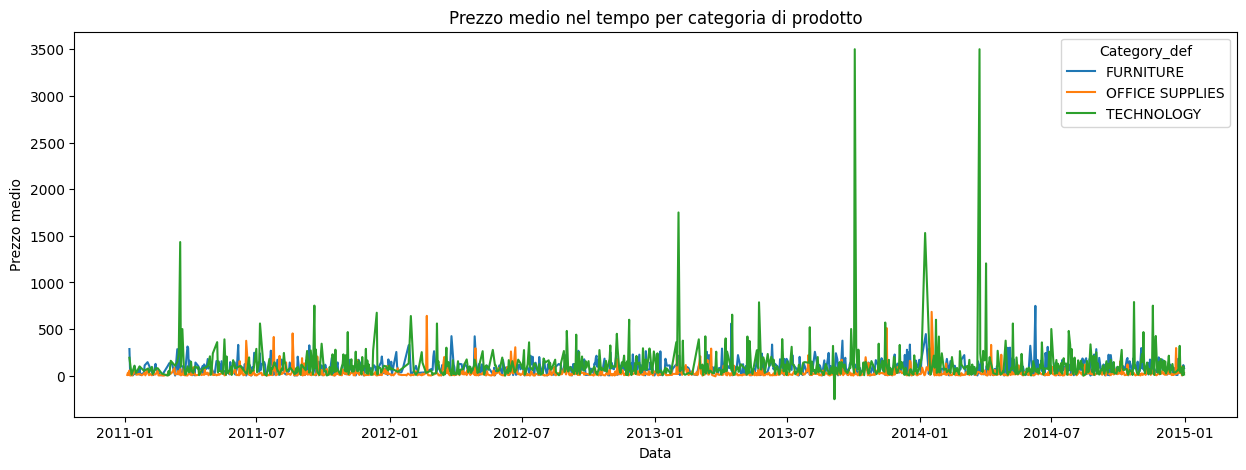

In [14]:
'''PREZZO MEDIO NEL TEMPO PER CATEGORIA DI PRODOTTO'''
df_merge_def['Price Single Product']=df_merge_def['Sales_def'] / df_merge_def['Quantity_def'] #mi trovo il prezzo del singolo prodotto

prezzo_per_cat=df_merge_def.groupby(['Category_def', 'Order Date_def'])['Price Single Product'].mean().reset_index()

plt.figure(figsize=(15,5))
sns.lineplot(data=prezzo_per_cat, x='Order Date_def', y='Price Single Product', hue='Category_def') #hue serve per colorare le linee
plt.title('Prezzo medio nel tempo per categoria di prodotto')
plt.xlabel('Data')
plt.ylabel('Prezzo medio')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

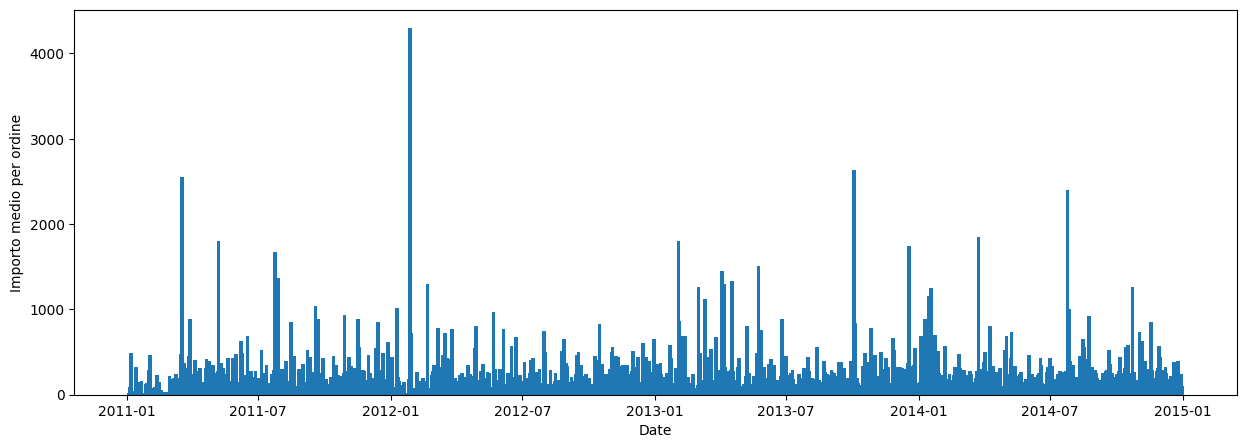

In [15]:
'''IMPORTO MEDIO PER ORDINE NEL TEMPO'''
importo_medio_per_ordine=df_merge_def.groupby(['Order Date_def'])['Sales_def'].mean().reset_index()

plt.figure(figsize=(15,5))
plt.bar(importo_medio_per_ordine['Order Date_def'], importo_medio_per_ordine['Sales_def'], width=5)
plt.xlabel('Date')
plt.ylabel('Importo medio per ordine')
plt.show

/var/folders/92/7kxqqyld1rl76prg4ll1c3s40000gn/T/ipykernel_87472/3262361568.py:7: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



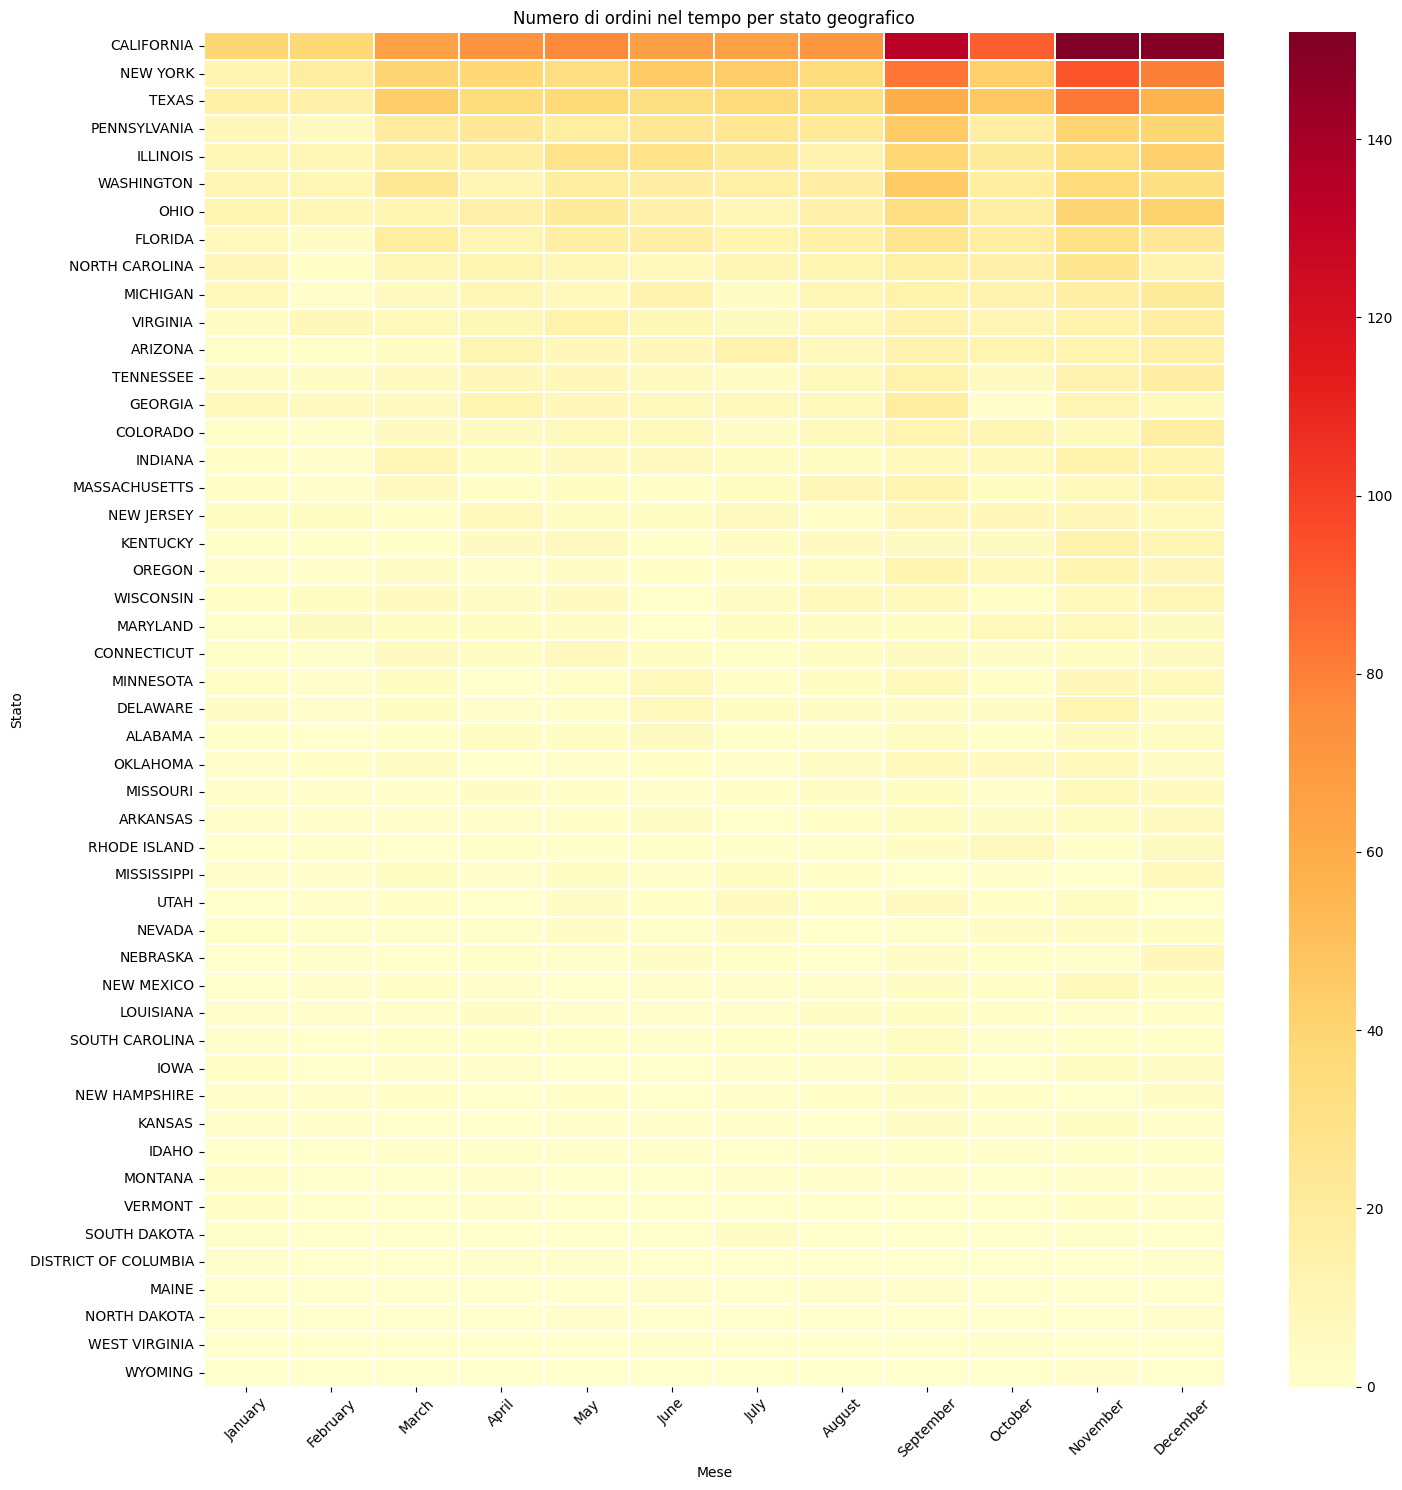

In [26]:
'''NUMERO DI ORDINI DIVERSI PER CIASCUNO STATO PER MESE'''
df_merge_def['Order Month'] = pd.Categorical(
    df_merge_def['Order Month'],
    categories=ordine_mesi,
    ordered=True
)
ordini_geo = df_merge_def.groupby(['State_def', 'Order Month'])['Order ID'].nunique().unstack(fill_value=0) #"Srotola" i mesi (Order Month) in colonne. Il risultato è una matrice con: Righe = Stati, Colonne = Mesi, Celle = Numero di ordini unic

ordini_geo_sorted = ordini_geo.loc[ordini_geo.sum(axis=1).sort_values(ascending=False).index]

# 3. Plot della heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(ordini_geo_sorted, cmap='YlOrRd', linewidths=0.3) #cmap specifica la scala di colori, in questo caso: yellow(Yl), orange(Or) e red(Rd)
plt.title('Numero di ordini nel tempo per stato geografico')
plt.xlabel('Mese')
plt.ylabel('Stato')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/var/folders/92/7kxqqyld1rl76prg4ll1c3s40000gn/T/ipykernel_87472/799181105.py:14: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/92/7kxqqyld1rl76prg4ll1c3s40000gn/T/ipykernel_87472/799181105.py:14: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/92/7kxqqyld1rl76prg4ll1c3s40000gn/T/ipykernel_87472/799181105.py:14: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/92/7kxqqyld1rl76prg4ll1c3s4

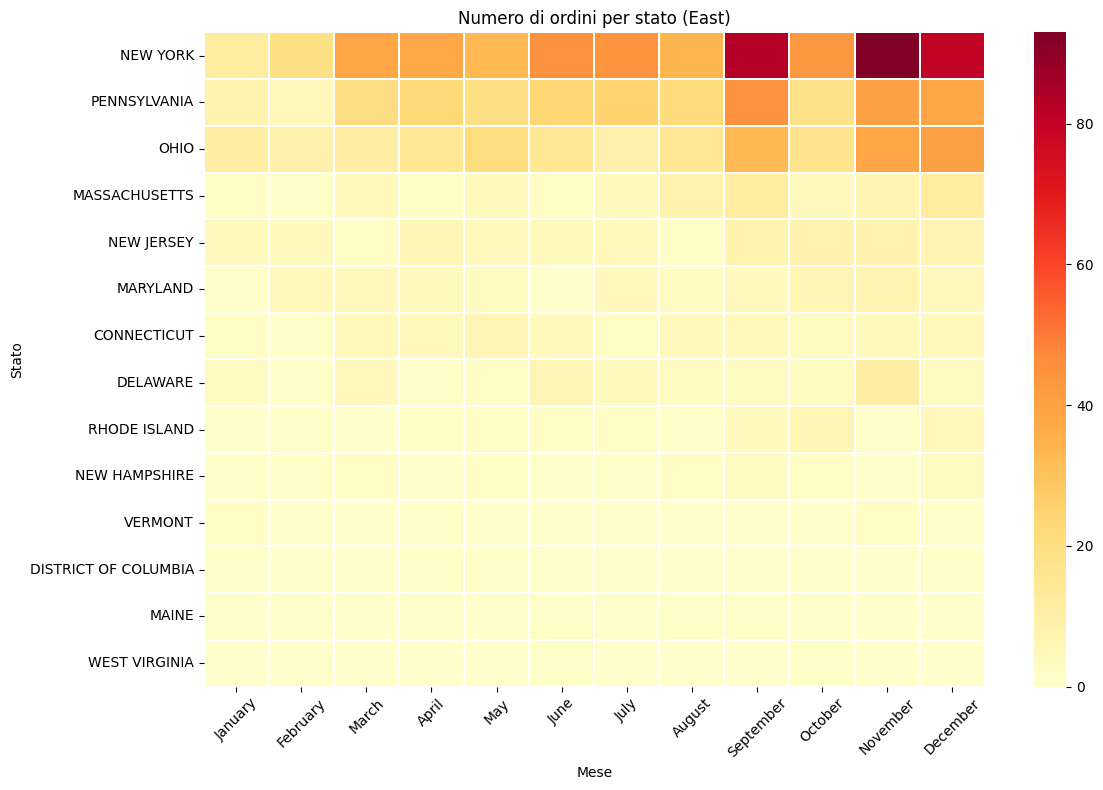

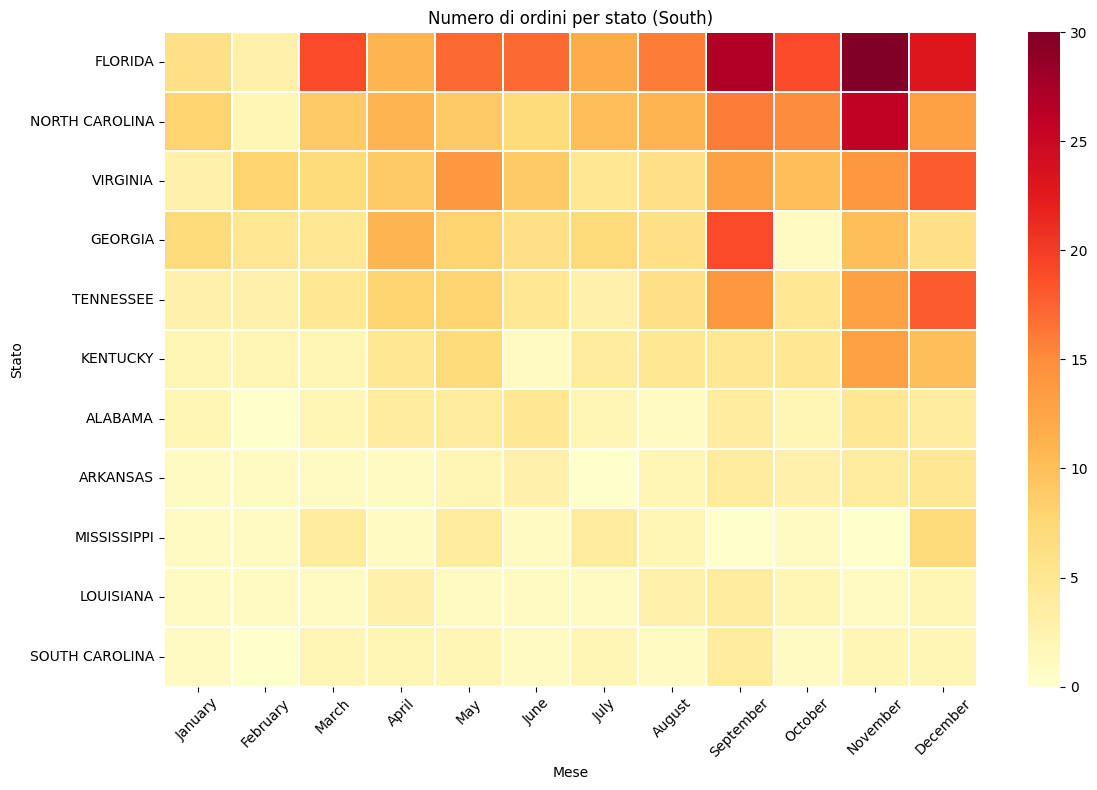

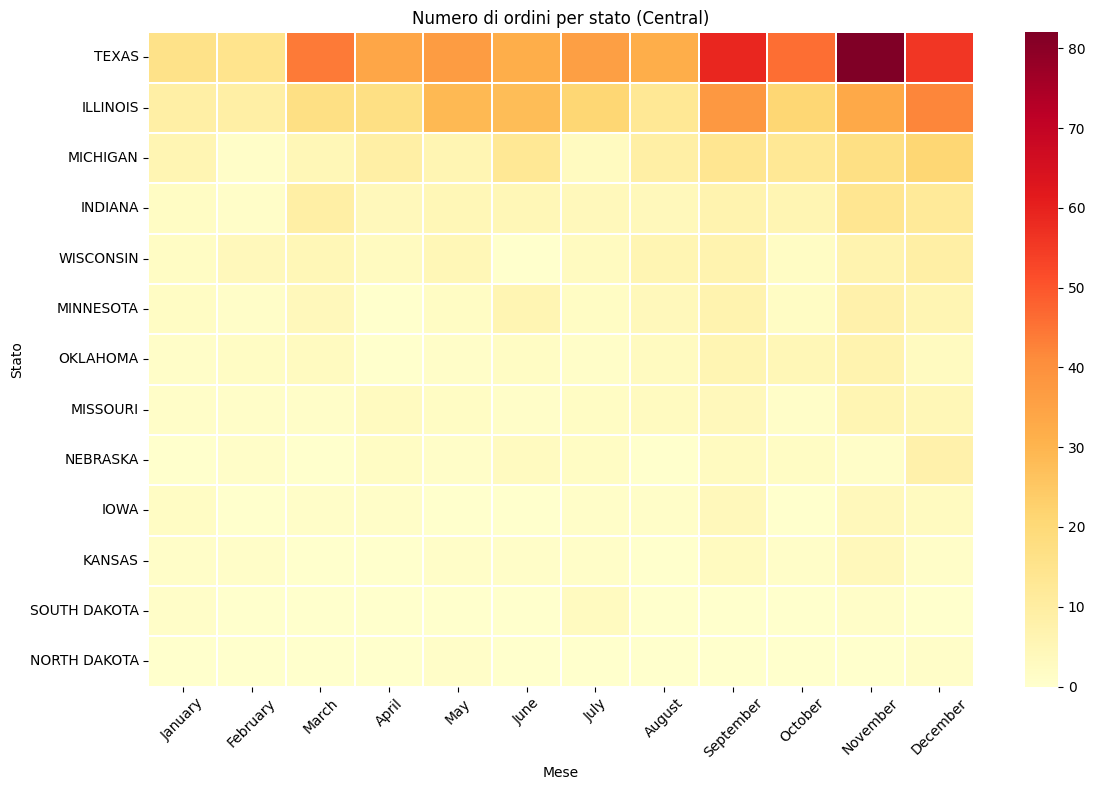

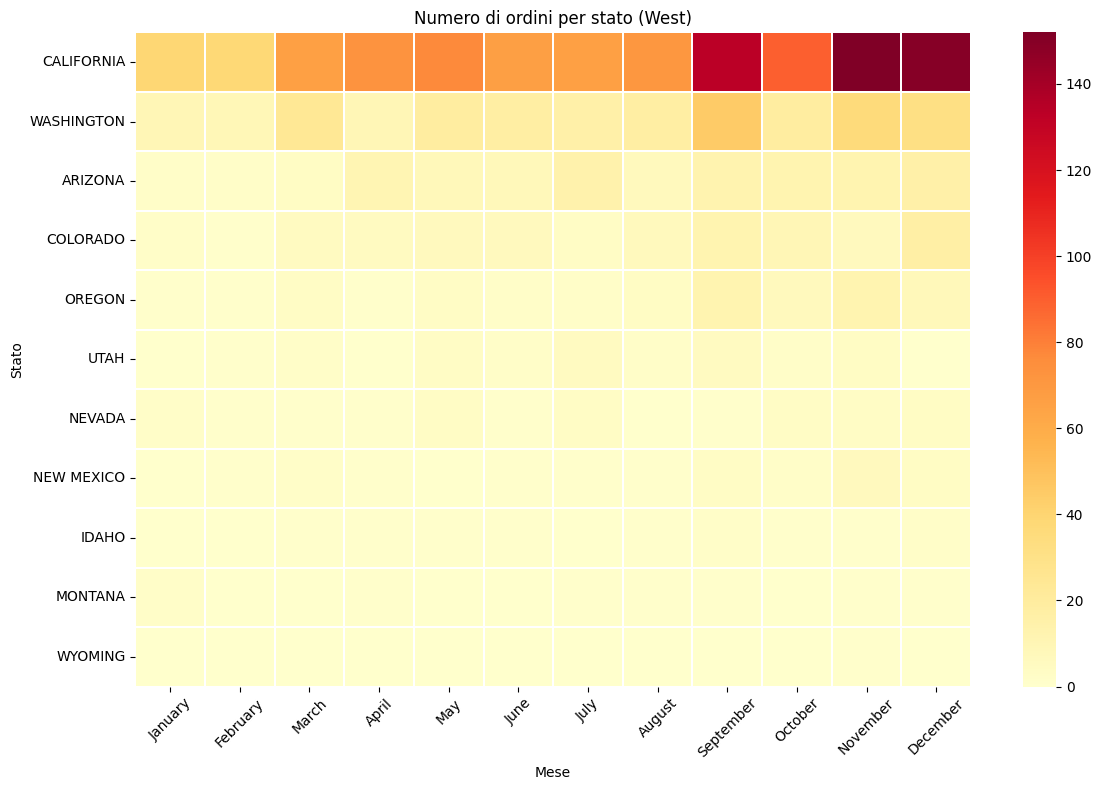

In [29]:
# Assicuriamoci che i mesi siano ordinati
df_merge_def['Order Month'] = pd.Categorical(
    df_merge_def['Order Month'],
    categories=ordine_mesi,
    ordered=True
)

# Ciclo sulle regioni
for regione in df_merge_def['Region'].unique():
    # filtro solo quella regione
    df_regione = df_merge_def[df_merge_def['Region'] == regione]

    # creo matrice stati × mesi
    ordini_state = df_regione.groupby(['State_def', 'Order Month'])['Order ID'].nunique().unstack(fill_value=0)

    if ordini_state.empty:   # se la regione non ha dati, skippo
        continue

    # ordino gli stati in base al totale ordini (dall’alto al basso)
    ordini_state_sorted = ordini_state.loc[ordini_state.sum(axis=1).sort_values(ascending=False).index]

    # heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(ordini_state_sorted, cmap="YlOrRd", linewidths=0.3)
    plt.title(f"Numero di ordini per stato ({regione})")
    plt.xlabel("Mese")
    plt.ylabel("Stato")
    plt.xticks(rotation=45)
    plt.tight_layout()



## ANALISI GEOGRAFICHE SULLE VENDITE

In [17]:
'''ANALISI SALES PER CIASCUNO STATO AMERICANO CON MAPPA USA'''

state_to_code = {
    'ALABAMA': 'AL', 'ALASKA': 'AK', 'ARIZONA': 'AZ', 'ARKANSAS': 'AR',
    'CALIFORNIA': 'CA', 'COLORADO': 'CO', 'CONNECTICUT': 'CT', 'DELAWARE': 'DE',
    'FLORIDA': 'FL', 'GEORGIA': 'GA', 'HAWAII': 'HI', 'IDAHO': 'ID',
    'ILLINOIS': 'IL', 'INDIANA': 'IN', 'IOWA': 'IA', 'KANSAS': 'KS',
    'KENTUCKY': 'KY', 'LOUISIANA': 'LA', 'MAINE': 'ME', 'MARYLAND': 'MD',
    'MASSACHUSETTS': 'MA', 'MICHIGAN': 'MI', 'MINNESOTA': 'MN', 'MISSISSIPPI': 'MS',
    'MISSOURI': 'MO', 'MONTANA': 'MT', 'NEBRASKA': 'NE', 'NEVADA': 'NV',
    'NEW HAMPSHIRE': 'NH', 'NEW JERSEY': 'NJ', 'NEW MEXICO': 'NM',
    'NEW YORK': 'NY', 'NORTH CAROLINA': 'NC', 'NORTH DAKOTA': 'ND',
    'OHIO': 'OH', 'OKLAHOMA': 'OK', 'OREGON': 'OR', 'PENNSYLVANIA': 'PA',
    'RHODE ISLAND': 'RI', 'SOUTH CAROLINA': 'SC', 'SOUTH DAKOTA': 'SD',
    'TENNESSEE': 'TN', 'TEXAS': 'TX', 'UTAH': 'UT', 'VERMONT': 'VT',
    'VIRGINIA': 'VA', 'WASHINGTON': 'WA', 'WEST VIRGINIA': 'WV',
    'WISCONSIN': 'WI', 'WYOMING': 'WY'
}

df_state_sales = df_merge_def.groupby('State_def')['Sales_def'].sum().reset_index()
df_state_sales['state_code'] = df_state_sales['State_def'].map(state_to_code) #funziona solo con gli stati scritti come sigle, quindi è necessario fare questa mappatura

fig = px.choropleth(        #mappa coropletica interattiva
    df_state_sales,
    locations='state_code',         # Colonna con la sigla dello stato
    locationmode='USA-states', # locationmode specifica che il comando locations contiene le sigle degli stati(e non il nome completo)
    color='Sales_def',             # Variabile da usare per colorare gli stati
    scope='usa',               # scope serve per specificare che serve solo la mappa USA e non del mondo intero
    color_continuous_scale='Turbo', #questo comando serve per la scala di colori da usare
    title='Vendite per Stato'
)
fig.show()


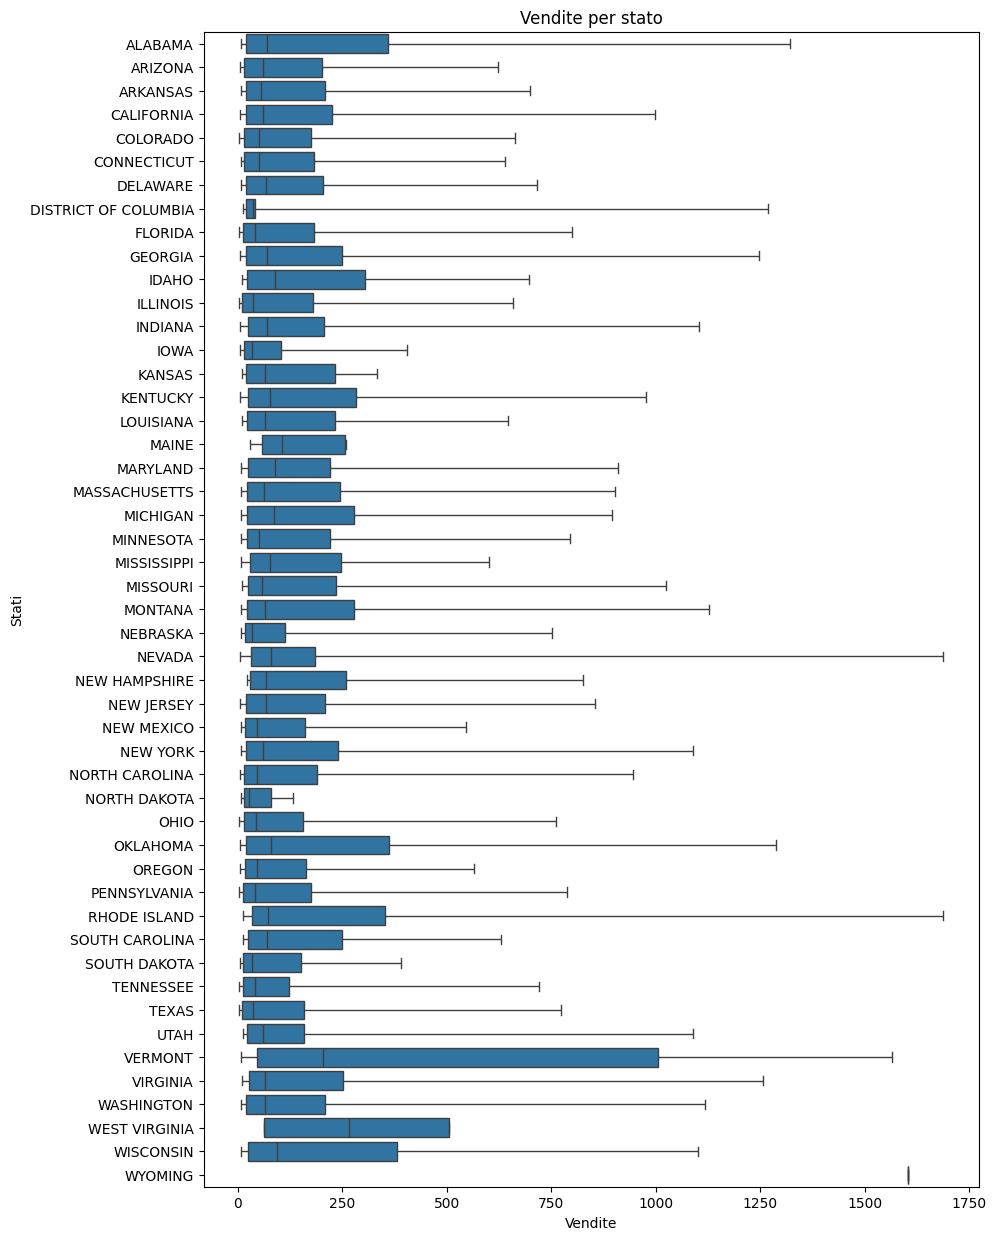

In [18]:
'''ANALISI SALES PER CIASCUN STATO CON BOXPLOT'''
plt.figure(figsize=(10,15))
df_sorted = df_merge_def.sort_values(by='State_def')
sns.boxplot(data=df_sorted, x='Sales_def',y='State_def', whis=(5,95), showfliers=False)
#plt.xticks(rotation=90)
plt.title('Vendite per stato')
plt.xlabel('Vendite')
plt.ylabel('Stati')
plt.show()

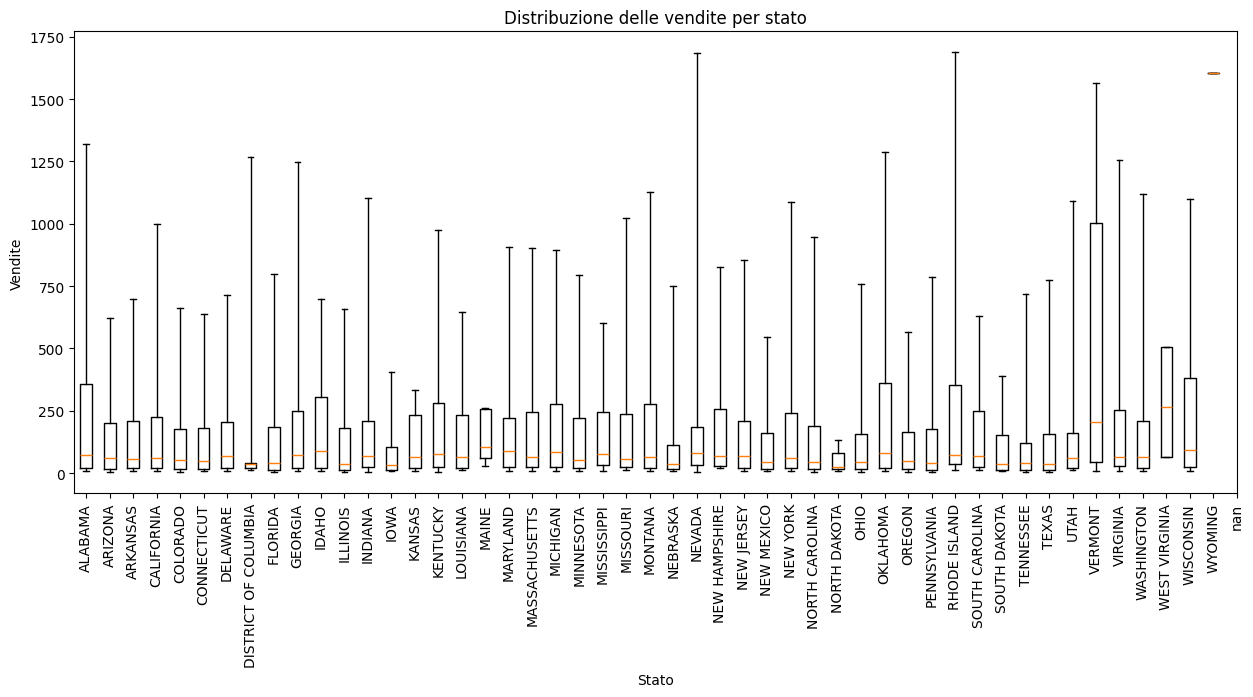

In [19]:
'''BOXPLOT CON MATPLOTLIB'''

# 1. Prepara i dati: una lista di liste, una per ogni stato
dati_per_stato = [group['Sales_def'].values for name, group in df_merge_def.groupby('State_def')]

# 2. Prendi i nomi degli stati per etichettare l'asse X
nomi_stati = df_merge_def['State_def'].sort_values().unique()

# 3. Crea il boxplot
plt.figure(figsize=(15, 6))
plt.boxplot(dati_per_stato, showfliers=False, whis=(5, 95))
plt.xticks(ticks=range(1, len(nomi_stati)+1), labels=nomi_stati, rotation=90) #ticks specifica dove posizionare le etichette sull'asse x, labels=noim_stati Assegna a ciascun tick la sua etichetta testuale, rotation ruota le etichette di 90 gradi, cioè le mette verticali
plt.title("Distribuzione delle vendite per stato")
plt.xlabel("Stato")
plt.ylabel("Vendite")
#plt.tight_layout()
plt.show()

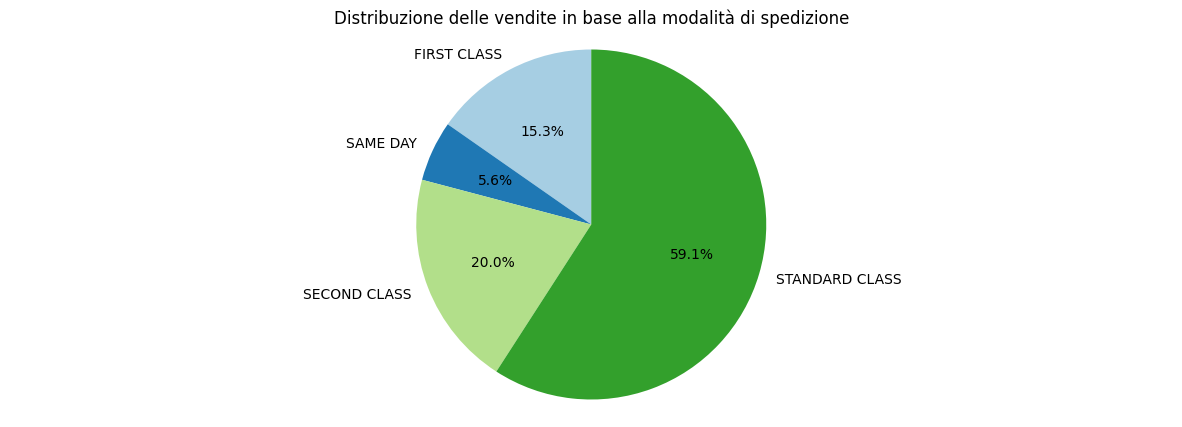

In [20]:
'''ANALISI SALES IN BASE ALLO SHIP MODE'''
vendite_per_ship_mode=df_merge_def.groupby('Ship Mode_def')['Sales_def'].sum().reset_index()
plt.figure(figsize=(15,5))
plt.pie(
    vendite_per_ship_mode['Sales_def'], #valori
    labels=vendite_per_ship_mode['Ship Mode_def'], #etichette
    autopct='%1.1f%%', #percentuale con un numero decimale
    startangle=90, #angolo di partenza
    colors=plt.cm.Paired.colors 
)
plt.title('Distribuzione delle vendite in base alla modalità di spedizione')
plt.axis('equal')  # Per avere la torta rotonda
plt.show()

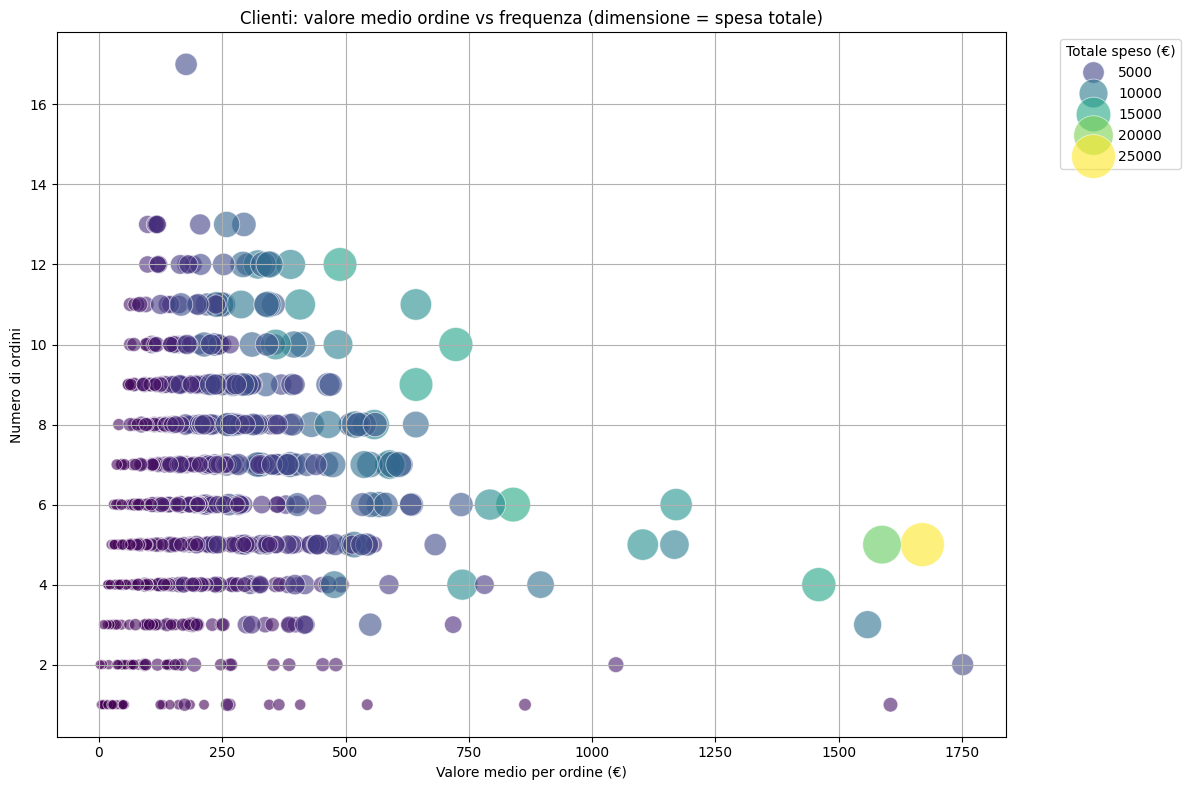

In [21]:
'''ANALISI DEI CLIENTI IN TERMINI DI NUMERO DI ORDINI, VALORE MEDIO DELL'ORDINE E SPESA TOTALE DELL'ORDINE'''
df_clienti = df_merge_def.groupby('Customer ID_def').agg(
    avg_order_value=('Sales_def', 'mean'),
    order_count=('Order ID', 'nunique'),
    total_spent=('Sales_def', 'sum')
).reset_index()

plt.figure(figsize=(12, 8))
# Bubble plot: usa 'size' per indicare la spesa totale
sns.scatterplot(
    data=df_clienti,
    x='avg_order_value',
    y='order_count',
    size='total_spent',
    hue='total_spent',
    palette='viridis', #questi sono i colori
    sizes=(50, 1000),  # Dimensioni min e max delle bolle
    alpha=0.6, #alpha viene usato per definire il livello di opacità-> alpha=1 signifca che è completamente opaco, alpha=0.6 significa che 0.6 opaco e 0.4 trasparente
    legend='brief' #La legenda mostra sia dimensione che colore se legend='brief' è attivo
)

plt.title('Clienti: valore medio ordine vs frequenza (dimensione = spesa totale)')
plt.xlabel('Valore medio per ordine (€)')
plt.ylabel('Numero di ordini')
plt.legend(title='Totale speso (€)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.show()

/var/folders/92/7kxqqyld1rl76prg4ll1c3s40000gn/T/ipykernel_87472/3267385764.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/92/7kxqqyld1rl76prg4ll1c3s40000gn/T/ipykernel_87472/3267385764.py:3: FutureWarning:



The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.



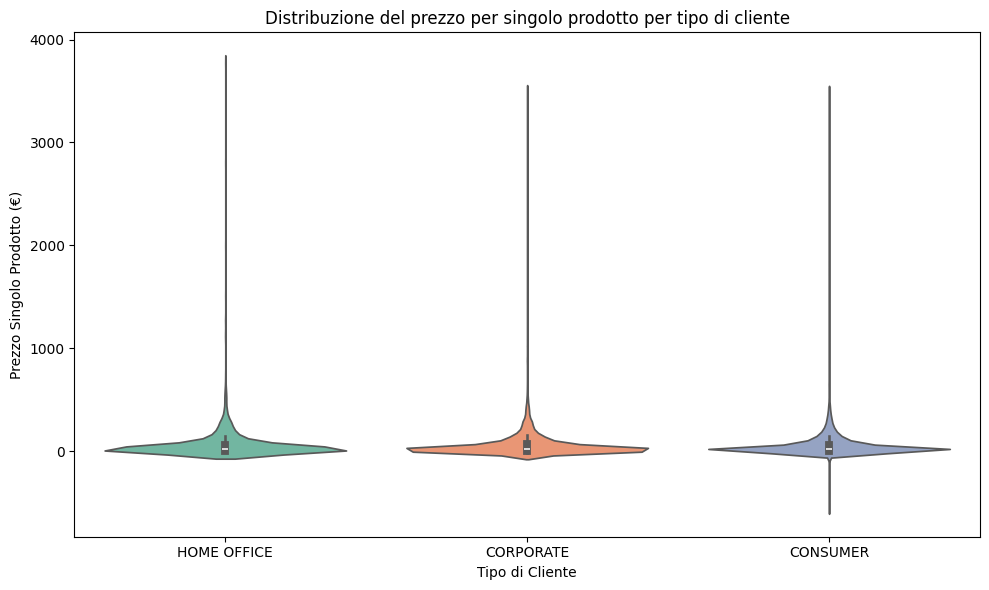

/var/folders/92/7kxqqyld1rl76prg4ll1c3s40000gn/T/ipykernel_87472/3267385764.py:22: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/92/7kxqqyld1rl76prg4ll1c3s40000gn/T/ipykernel_87472/3267385764.py:22: FutureWarning:



The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.



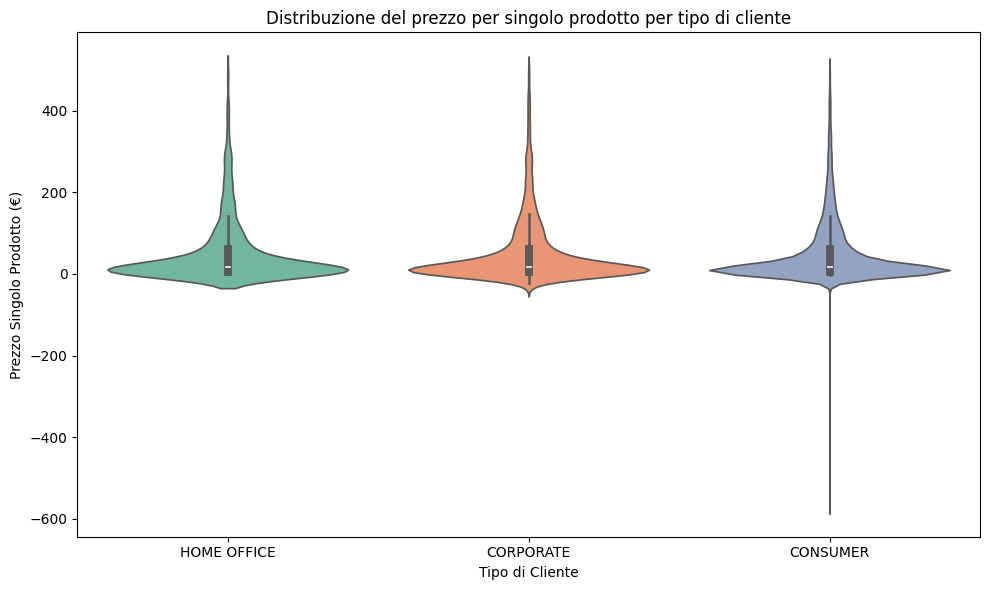

In [22]:
'''ANALISI DEL PREZZO DEI SINGOLI PRODOTTI ACQUISTATI IN BASE AL SEGMENTO DI CLIENTE '''
plt.figure(figsize=(10, 6))
sns.violinplot(
    data=df_merge_def,
    x='Segment_def', 
    y='Price Single Product',
    palette='Set2',
    inner='box',       # mostra anche il boxplot centrale
    scale='width'      # i violini sono scalati in larghezza rispetto alla densità
)

plt.title('Distribuzione del prezzo per singolo prodotto per tipo di cliente')
plt.xlabel('Tipo di Cliente')
plt.ylabel('Prezzo Singolo Prodotto (€)')
plt.tight_layout()
plt.show()


'''Guardo solo per i prezzi inferiori a 500€'''
df_filtrato=df_merge_def[df_merge_def['Price Single Product'] <= 500]
plt.figure(figsize=(10, 6))
sns.violinplot(
    data=df_filtrato,
    x='Segment_def', 
    y='Price Single Product',
    palette='Set2',
    inner='box',       
    scale='width')      

plt.title('Distribuzione del prezzo per singolo prodotto per tipo di cliente')
plt.xlabel('Tipo di Cliente')
plt.ylabel('Prezzo Singolo Prodotto (€)')
plt.tight_layout()
plt.show()

## ANALISI SCONTO

,Order ID,Product ID_def,Customer ID_def,Country,Region,State_def,City_def,Postal Code_def,Order Date_def,Ship Date_def,...,Category_def,Sub-Category_def,Order Month,Order Year,Order Quarter,Days between order date and shipping date,Order Day Type,Order Week,Order Day of the Week,Price Single Product
1860,CA-2011-122931,FUR-TA-10004147,SM-20950,United States,East,PENNSYLVANIA,PHILADELPHIA,19134,2011-09-29,2011-10-03,...,FURNITURE,TABLES,September,2011,3,4 days,Weekday,39,Thursday,67.176
2067,US-2014-110149,OFF-BI-10000014,WB-21850,United States,East,PENNSYLVANIA,PHILADELPHIA,19143,2014-12-11,2014-12-14,...,OFFICE SUPPLIES,BINDERS,December,2014,4,3 days,Weekday,50,Thursday,3.273
4127,CA-2011-121769,FUR-TA-10004442,JS-15880,United States,East,OHIO,TOLEDO,43615,2011-04-08,2011-04-12,...,FURNITURE,TABLES,April,2011,2,4 days,Weekday,14,Friday,172.110
7062,CA-2014-102414,TEC-PH-10002923,JA-15970,United States,West,ARIZONA,PHOENIX,85023,2014-05-16,2014-05-19,...,TECHNOLOGY,PHONES,May,2014,2,3 days,Weekday,20,Friday,29.592
9652,CA-2012-154970,FUR-CH-10003396,SR-20740,United States,West,WASHINGTON,SEATTLE,98103,2012-01-05,2012-01-10,...,FURNITURE,CHAIRS,January,2012,1,5 days,Weekday,1,Thursday,61.584


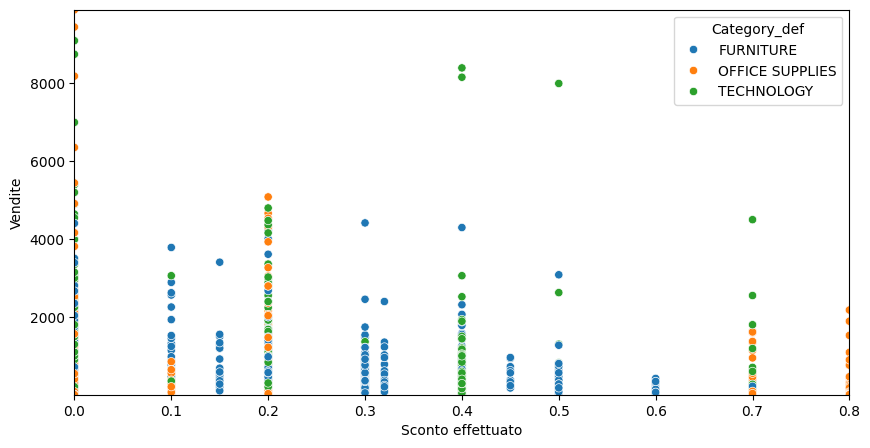

In [23]:
#domanda: maggiore lo sconto maggiore sono le vendite?

d001=df_merge_def['Discount_def'].quantile(0.001)
d999=df_merge_def['Discount_def'].quantile(0.999)
s0005=df_merge_def['Sales_def'].quantile(0.0005)
s9995=df_merge_def['Sales_def'].quantile(0.9995)
display(df_merge_def.loc[df_merge_def['Discount_def']>3])

plt.figure(figsize=(10,5))
sns.scatterplot(data=df_merge_def, x='Discount_def', y='Sales_def', hue='Category_def' ,markers=True)
plt.xlim(d001,d999)  # Zoom su intervallo x utile
plt.ylim(s0005,s9995)  # Zoom su intervallo y utile
plt.xlabel('Sconto effettuato')
plt.ylabel('Vendite')
plt.show()

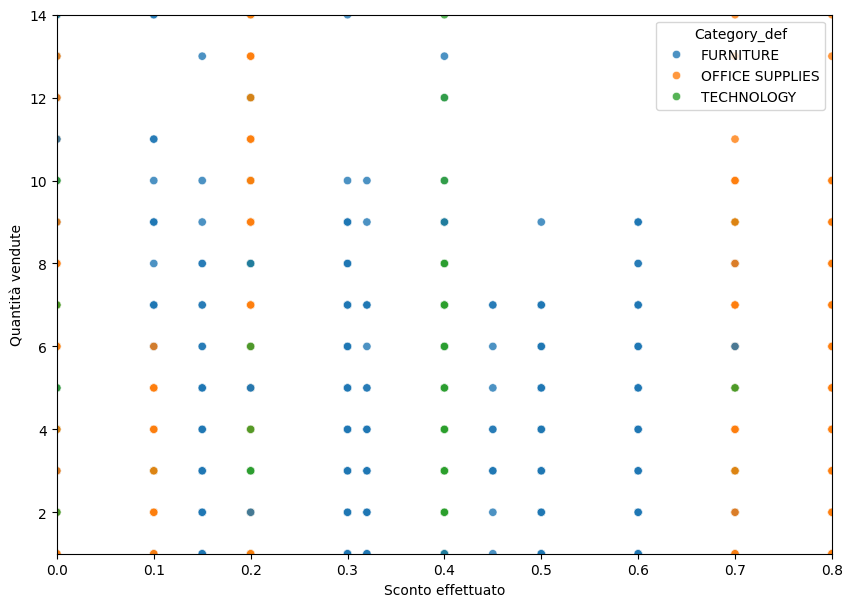

In [24]:
'''RELAZIONE SCONTO-QUANTITA'''
q5=df_merge_def['Quantity_def'].quantile(0.005)
q95=df_merge_def['Quantity_def'].quantile(0.9995)

d10=df_merge_def['Discount_def'].quantile(0.005)
d90=df_merge_def['Discount_def'].quantile(0.995)

plt.figure(figsize=(10,7))
sns.scatterplot(data=df_merge_def, x='Discount_def', y='Quantity_def', hue='Category_def' ,markers=True, palette='tab10', alpha=0.8)
plt.xlim(d10,d90)
plt.ylim(q5,q95)  # Zoom su intervallo utile
plt.xlabel('Sconto effettuato')
plt.ylabel('Quantità vendute')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

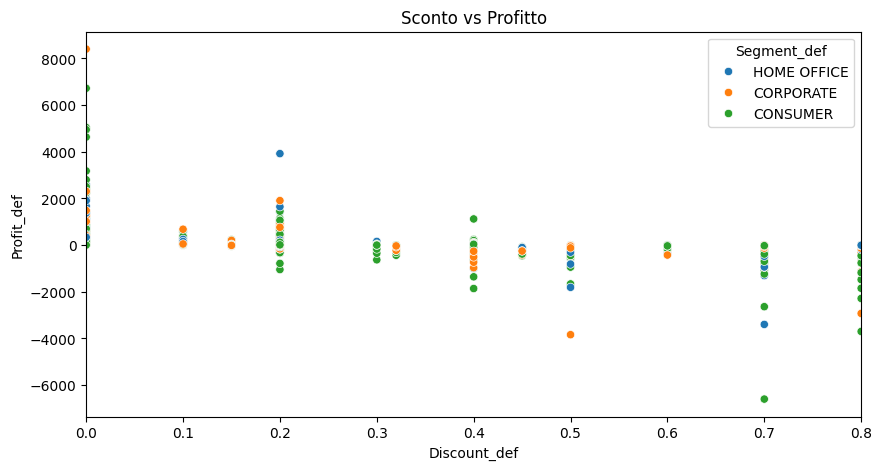

In [25]:
'''SCONTO VS PROFITTO'''
plt.figure(figsize=(10,5))
p10=df_merge_def['Profit_def'].quantile(0.10)
p90=df_merge_def['Profit_def'].quantile(0.90)
sns.scatterplot(data=df_merge_def, x='Discount_def', y='Profit_def', hue='Segment_def')
plt.xlim(d001,d999)
#plt.ylim(p10,p90)
plt.title('Sconto vs Profitto')
plt.show